In [7]:
import torch  # PyTorch for tensors and GPU support
import pandas as pd  # Pandas for handling CSV data
import numpy as np  # NumPy for numerical operations
from sklearn.model_selection import train_test_split  # For splitting the dataset
from torch_geometric.data import Data  # PyTorch Geometric for graph-based data handling


# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Automatically choose CPU or GPU
# Load gene expression matrix (genes as columns, samples as rows)
expression_df = pd.read_csv("DREAM5_insilico_data.tsv", sep="\t", header=0)
gene_ids = expression_df.columns.tolist()  # Get gene IDs from column names

# Convert expression matrix to node features tensor
node_features = torch.tensor(expression_df.values.T, dtype=torch.float)  # Don't move to device yet
print(f"Node features shape: {node_features.shape}")  # Check shape
node_features = node_features.to(device)  # Now move to device

# Load mutual information data (edges) with columns: 'Gene1', 'Gene2', 'MI'
mi_df = pd.read_csv("mi_matrix_pairs.csv")
mi_threshold = 0  # Set an MI threshold to filter strong interactions
mi_df = mi_df[mi_df['Mutual_Information'] > mi_threshold]

# Convert gene names to indices based on gene_ids list for compatibility with PyTorch Geometric
gene_to_idx = {gene: idx for idx, gene in enumerate(gene_ids)}

# Filter only valid gene pairs based on gene expression matrix columns
mi_df = mi_df[mi_df['Gene1'].isin(gene_to_idx) & mi_df['Gene2'].isin(gene_to_idx)]
mi_df['Gene1_idx'] = mi_df['Gene1'].map(gene_to_idx)
mi_df['Gene2_idx'] = mi_df['Gene2'].map(gene_to_idx)

# Convert to edge index tensor and edge weight tensor
edge_index = torch.tensor(mi_df[['Gene1_idx', 'Gene2_idx']].values.T, dtype=torch.long)  # Don't move to device yet
edge_index = edge_index.to(device)  # Now move to device
edge_weight = torch.tensor(mi_df['Mutual_Information'].values, dtype=torch.float).to(device)  # Move to device
print(f"Edge index shape: {edge_index.shape}")  # Check shape

# Load the ground truth interaction matrix (square matrix of 1s and 0s)
interaction_matrix = pd.read_csv("interaction.csv", header=0)
interaction_matrix = interaction_matrix.values  # Convert to numpy array

# Ensure the interaction matrix size is consistent
max_gene_idx = interaction_matrix.shape[0]  # This should be 100 based on your error

# Create ground truth labels for all gene pairs
interaction_pairs = []
ground_truth_labels = []

for i in range(interaction_matrix.shape[0]):
    for j in range(i + 1, interaction_matrix.shape[1]):  # Only consider the upper triangle to avoid duplicates
        interaction_pairs.append([i, j])
        ground_truth_labels.append(interaction_matrix[i, j])  # 1 if interaction, 0 if no interaction

# Convert the ground truth labels to a tensor
ground_truth_labels = torch.tensor(ground_truth_labels, dtype=torch.float).to(device)

# Split data into train, validation, and test sets
# First, split the edge indices and edge weights
edge_index_train, edge_index_temp, edge_weight_train, edge_weight_temp = train_test_split(
    edge_index.T.cpu().numpy(), edge_weight.cpu().numpy(), test_size=0.2, random_state=42
)
edge_index_val, edge_index_test, edge_weight_val, edge_weight_test = train_test_split(
    edge_index_temp, edge_weight_temp, test_size=0.2, random_state=42
)

# Convert back to tensors for PyTorch Geometric (on device)
edge_index_train = torch.tensor(edge_index_train.T, dtype=torch.long).to(device)
edge_weight_train = torch.tensor(edge_weight_train, dtype=torch.float).to(device)
edge_index_val = torch.tensor(edge_index_val.T, dtype=torch.long).to(device)
edge_weight_val = torch.tensor(edge_weight_val, dtype=torch.float).to(device)
edge_index_test = torch.tensor(edge_index_test.T, dtype=torch.long).to(device)
edge_weight_test = torch.tensor(edge_weight_test, dtype=torch.float).to(device)

# Sanity check for edge splits
print(f"Training edge indices: {edge_index_train.shape}")
print(f"Validation edge indices: {edge_index_val.shape}")
print(f"Test edge indices: {edge_index_test.shape}")

# Now we need to ensure that the ground truth labels match the edges for each set
# Extract corresponding ground truth labels for the splits
train_labels = []
for edge in edge_index_train.T:
    i, j = edge
    # Ensure that i and j are within bounds before accessing the interaction matrix
    if i < max_gene_idx and j < max_gene_idx:
        train_labels.append(interaction_matrix[i, j])  # Append the corresponding label

val_labels = []
for edge in edge_index_val.T:
    i, j = edge
    # Ensure that i and j are within bounds before accessing the interaction matrix
    if i < max_gene_idx and j < max_gene_idx:
        val_labels.append(interaction_matrix[i, j])  # Append the corresponding label

test_labels = []
for edge in edge_index_test.T:
    i, j = edge
    # Ensure that i and j are within bounds before accessing the interaction matrix
    if i < max_gene_idx and j < max_gene_idx:
        test_labels.append(interaction_matrix[i, j])  # Append the corresponding label

# Convert lists to tensors
train_labels = torch.tensor(train_labels, dtype=torch.float).to(device)
val_labels = torch.tensor(val_labels, dtype=torch.float).to(device)
test_labels = torch.tensor(test_labels, dtype=torch.float).to(device)

# Verify that the splits and labels match correctly
print(f"Training labels shape: {train_labels.shape}")
print(f"Validation labels shape: {val_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")

# Prepare PyTorch Geometric Data object for each split
train_data = Data(x=node_features, edge_index=edge_index_train, edge_attr=edge_weight_train, y=train_labels)
val_data = Data(x=node_features, edge_index=edge_index_val, edge_attr=edge_weight_val, y=val_labels)
test_data = Data(x=node_features, edge_index=edge_index_test, edge_attr=edge_weight_test, y=test_labels)

# Verify that the data is ready for training
print(f"Training data: {train_data}")
print(f"Validation data: {val_data}")
print(f"Test data: {test_data}")


Node features shape: torch.Size([1643, 805])
Edge index shape: torch.Size([2, 1124642])
Training edge indices: torch.Size([2, 899713])
Validation edge indices: torch.Size([2, 179943])
Test edge indices: torch.Size([2, 44986])
Training labels shape: torch.Size([814392])
Validation labels shape: torch.Size([162756])
Test labels shape: torch.Size([40679])
Training data: Data(x=[1643, 805], edge_index=[2, 899713], edge_attr=[899713], y=[814392])
Validation data: Data(x=[1643, 805], edge_index=[2, 179943], edge_attr=[179943], y=[162756])
Test data: Data(x=[1643, 805], edge_index=[2, 44986], edge_attr=[44986], y=[40679])


In [9]:
from torch_geometric.data import DataLoader
# Prepare the DataLoader for PyTorch Geometric Data objects (for train, validation, test)
train_loader = DataLoader([train_data], batch_size=1, shuffle=True)
val_loader = DataLoader([val_data], batch_size=1, shuffle=False)
test_loader = DataLoader([test_data], batch_size=1, shuffle=False)

C:\Users\ridhi\AppData\Roaming\Python\Python312\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/200, Train Loss: 1.9051, Val Loss: 0.1574
Epoch 2/200, Train Loss: 1.0793, Val Loss: 0.1044
Epoch 3/200, Train Loss: 0.8874, Val Loss: 0.1569
Epoch 4/200, Train Loss: 0.4530, Val Loss: 0.1860
Epoch 5/200, Train Loss: 0.3766, Val Loss: 0.1668
Epoch 6/200, Train Loss: 0.3149, Val Loss: 0.1294
Epoch 7/200, Train Loss: 0.2205, Val Loss: 0.1017
Epoch 8/200, Train Loss: 0.1801, Val Loss: 0.0910
Epoch 9/200, Train Loss: 0.1543, Val Loss: 0.0891
Epoch 10/200, Train Loss: 0.1374, Val Loss: 0.0882
Epoch 11/200, Train Loss: 0.1190, Val Loss: 0.0864
Epoch 12/200, Train Loss: 0.1103, Val Loss: 0.0843
Epoch 13/200, Train Loss: 0.1022, Val Loss: 0.0815
Epoch 14/200, Train Loss: 0.0967, Val Loss: 0.0767
Epoch 15/200, Train Loss: 0.0906, Val Loss: 0.0706
Epoch 16/200, Train Loss: 0.0845, Val Loss: 0.0653
Epoch 17/200, Train Loss: 0.0741, Val Loss: 0.0625
Epoch 18/200, Train Loss: 0.0712, Val Loss: 0.0616
Epoch 19/200, Train Loss: 0.0687, Val Loss: 0.0608
Epoch 20/200, Train Loss: 0.0672, Val Lo

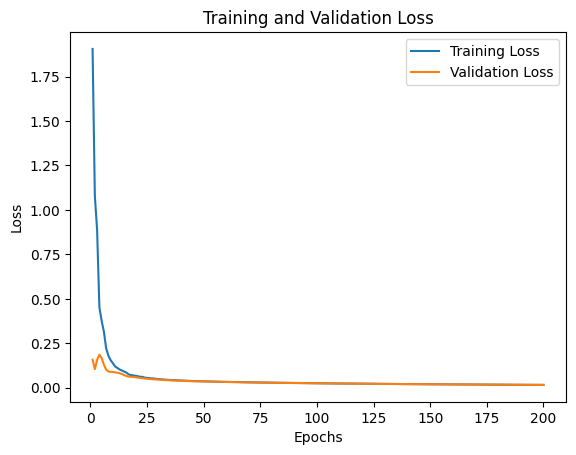

In [11]:
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, GraphConv
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader
import matplotlib.pyplot as plt

# Define the Enhanced Graph Autoencoder with regularization and attention-based enhancements
class EnhancedGraphAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(EnhancedGraphAutoencoder, self).__init__()

        # Encoder: Combination of GCN and GAT layers with skip connections
        self.encoder_gcn1 = GCNConv(input_dim, hidden_dim * 2, add_self_loops=True, normalize=True)
        self.encoder_gat = GATConv(hidden_dim * 2, hidden_dim, heads=4, concat=False, dropout=0.3)
        self.encoder_gat2 = GATConv(hidden_dim, hidden_dim, heads=4, concat=False, dropout=0.3)

        # Latent space: A non-linear transformation of the combined embeddings
        self.latent_transform = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )

        # Decoder: Multi-layer perceptron with ReLU activations and dropout
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.5),  # Apply dropout
            nn.Linear(hidden_dim * 2, input_dim)
        )

        # Residual connection (identity mapping)
        self.residual = nn.Linear(input_dim, input_dim)

        # Regularization (Laplacian smoothing penalty)
        self.laplacian_penalty = 1e-3

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Propagation and transformation in the encoder
        x_gcn = self.encoder_gcn1(x, edge_index)
        x_gcn = torch.relu(x_gcn)
        x_gat = self.encoder_gat(x_gcn, edge_index)
        x_gat2 = self.encoder_gat2(x_gat, edge_index)

        # Latent space transformation
        latent = self.latent_transform(x_gat2)

        # Decoding and residual mapping
        decoded = self.decoder(latent)
        decoded_residual = self.residual(data.x)

        return decoded + decoded_residual, latent  # Return decoded matrix and latent embeddings

    def compute_laplacian_loss(self, x, edge_index):
        # Compute smoothness penalty using Laplacian
        row, col = edge_index
        diff = x[row] - x[col]
        laplacian_loss = self.laplacian_penalty * torch.sum(torch.norm(diff, dim=1) ** 2)
        return laplacian_loss

# Initialize the model, optimizer, and loss function
input_dim = node_features.shape[1]  # Number of input features (genes)
hidden_dim = 256  # Latent space dimension

model = EnhancedGraphAutoencoder(input_dim=input_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()

# Training loop with Laplacian loss and advanced regularization
def train_autoencoder(train_loader, val_loader, model, optimizer, criterion, num_epochs=200):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            output, embeddings = model(data)
            loss = criterion(output, data.x)  # Reconstruction loss
            
            # Add Laplacian regularization
            laplacian_loss = model.compute_laplacian_loss(embeddings, data.edge_index)
            total_loss = loss + laplacian_loss
            
            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()

        # Log training loss
        train_losses.append(running_loss / len(train_loader))
        
        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                output, _ = model(data)
                loss = criterion(output, data.x)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
    
    return train_losses, val_losses

# Train the enhanced model
train_losses, val_losses = train_autoencoder(train_loader, val_loader, model, optimizer, criterion)

# Plot Training and Validation Loss
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


AUROC: 0.9704
AUPR: 0.9752
Matthews Correlation Coefficient (MCC): 0.8100


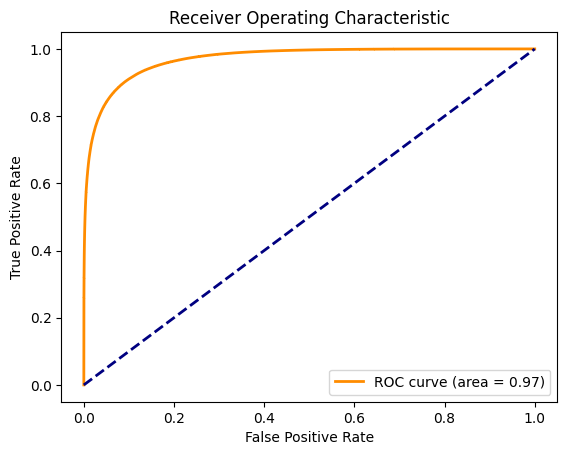

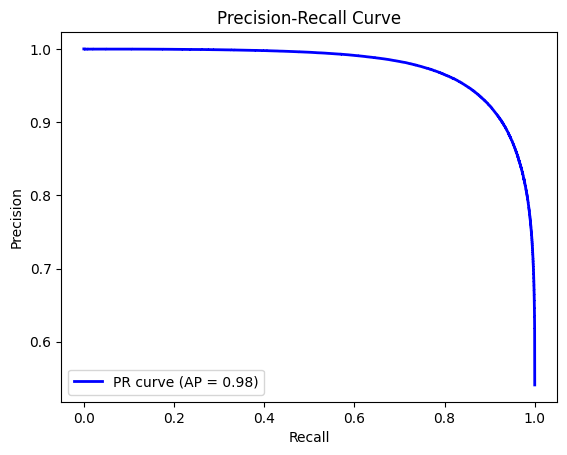

In [13]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, matthews_corrcoef
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model
def evaluate_model(val_loader, model):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            output, _ = model(data)
            all_labels.append(data.x.cpu().numpy())  # True data (gene expression)
            all_preds.append(output.cpu().numpy())   # Predicted data (reconstructed expression)

    # Flatten the lists for ROC and PR calculations
    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    # You may need to define your own threshold based on the problem
    all_labels_binary = (all_labels > 0.5).astype(int)  # Threshold at 0.5
    all_preds_binary = (all_preds > 0.5).astype(int)

    return all_labels_binary, all_preds_binary, all_preds

# Get predictions
y_true, y_pred_binary, y_pred_prob = evaluate_model(test_loader, model)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true.flatten(), y_pred_prob.flatten())
roc_auc = auc(fpr, tpr)

# Calculate PR curve
precision, recall, _ = precision_recall_curve(y_true.flatten(), y_pred_prob.flatten())
average_precision = average_precision_score(y_true.flatten(), y_pred_prob.flatten())

# Calculate MCC
mcc = matthews_corrcoef(y_true.flatten(), y_pred_binary.flatten())

# Print AUPR, AUROC, and MCC
print(f'AUROC: {roc_auc:.4f}')
print(f'AUPR: {average_precision:.4f}')
print(f'Matthews Correlation Coefficient (MCC): {mcc:.4f}')

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Plot PR curve
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()
